In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('ticks',
              rc={'axes.facecolor': (0, 0, 0, 0)})
sns.set_context('talk')

from matplotlib import rcParams, colors, cm
import matplotlib.patches as mpatches
rcParams['font.family'] = 'sans-serif'
rcParams['figure.dpi'] = 150

In [2]:
import os
import math
import random
import warnings
import numpy as np
import pandas as pd
import networkx as nx
from scipy import stats
# local import
from utils import read_mi
from utils import get_rbd_mutated
from utils import AFFINITY, ESCAPE, MOI

In [3]:
m = pd.read_csv('coefficients_2nd_order.tsv', sep='\t')

m['pos1'] = [int(x[1:-1]) for x in m['Term 1'].values]
m['pos2'] = [int(x[1:-1]) for x in m['Term 2'].values]

m = m.pivot_table(index='pos1', columns='pos2', values='Coefficient')
m = m.mask(np.triu(np.ones(m.shape)).astype(bool)).stack()

m.name = 'coefficient'

EPISTASIS = set()
for p1, p2 in m[m > 0.15].index:
    EPISTASIS.add(tuple(sorted((p1, p2))))
EPI_PAIRS_SORTED = []
for p1, p2 in m[m > 0.15].sort_values(ascending=False).index:
    p1, p2 = tuple(sorted((p1, p2)))
    EPI_PAIRS_SORTED.append(f'{p1}-{p2}')

In [4]:
EPI_PAIRS = {f'{x}-{y}'
             for x, y in EPISTASIS}

In [5]:
def rbd_network(a, mutated=None, save_gml=None, sample=1, n_random=1000):
    if mutated is None:
        mutated = range(319, 541)
    
    g = nx.Graph()
    for p0, p1 in a[(a['gene_source'] == 'S') &
                    (a['gene_target'] == 'S') &
                    (a['feature_codon_source'] >= 319) &
                    (a['feature_codon_source'] <= 540) &
                    (a['feature_codon_target'] >= 319) &
                    (a['feature_codon_target'] <= 540)][[
            'feature_codon_source',
            'feature_codon_target']].sample(frac=sample).values:
        g.add_edge(int(p0), int(p1))

    for edge in g.edges:
        if edge in EPISTASIS:
            etype = 'epistasis'
            n1, n2 = edge
            n1type = 'epistasis'
            n2type = 'epistasis'
        else:
            etype = 'other'
            n1, n2 = edge
            n1type = 'other'
            n2type = 'other'
        g.edges[edge]['type'] = etype
        g.nodes[n1]['type'] = n1type
        g.nodes[n2]['type'] = n2type
        
    if save_gml is not None:
        nx.write_gml(g, save_gml)

    random.seed(100)

    cg = [sorted((x, y)) for x, y in g.edges]
    yield (np.array([1 if (x, y) in EPISTASIS
                     else 0
                     for x, y in cg]),
           'original')

    for _ in range(n_random):
        n_nodes = len(g.nodes)
        n_edges = len(g.edges)
        r = nx.Graph()
        nodes = list({x for x in range(319, 541) if x in mutated})
        if len(nodes) < len(g.nodes):
            nodes = list(g.nodes)
        while len(r.edges) < n_edges:
            n1 = random.choice(nodes)
            n2 = random.choice(nodes)
            if n1 != n2 and abs(n1 - n2) > 1:
                r.add_edge(n1, n2)
        cg = [(x, y) for x, y in r.edges]
        yield (np.array([1 if (x, y) in EPISTASIS
                         else 0
                         for x, y in cg]),
               'random')

def enrichment_score(*g):
    g = g[0]
    
    RBD_LENGTH = 540 - 319 + 1
    
    all_possible = math.factorial(RBD_LENGTH) / (math.factorial(2) * math.factorial(RBD_LENGTH - 2))
    int_rel = g.sum()
    int_not = g.shape[0] - int_rel
    all_possible_rel = len(EPISTASIS)
    not_int_rel = all_possible_rel - int_rel
    not_int_not_rel = all_possible - not_int_rel - int_not - int_rel

    table = [[int_rel, not_int_rel],
             [int_not, not_int_not_rel]]
    odds_ratio, pvalue = stats.fisher_exact(table,
                                            alternative='greater')

    return odds_ratio


def enrichment(a, mutated=None, save_gml=None, sample=1, n_random=1000):
    res = []
    for g, ntype in rbd_network(a, save_gml=save_gml,
                                mutated=mutated, sample=sample,
                                n_random=n_random):
        odds_ratio = enrichment_score(g)
        if ntype == 'original':
            try:
                ci = stats.bootstrap((g,), enrichment_score, n_resamples=999,
                                     confidence_level=0.95)
                high = ci.confidence_interval.high
                low = ci.confidence_interval.low
            except ValueError:
                high = np.nan
                low = np.nan    
        else:
            high = np.nan
            low = np.nan

        res.append((ntype, odds_ratio, low, high))

    df = pd.DataFrame(res,
                      columns=['type', 'odds-ratio', 'low', 'high'])

    return df

In [6]:
name = 'all'
df = read_mi('../out/all-notime/mi_annotated.tsv.gz',
             name,
             date=False)

In [7]:
e = enrichment(df)
e.groupby('type').median()

,odds-ratio,low,high
type,,,
original,320.300654,0.0,2262.184615
random,0.000000,NaN,NaN


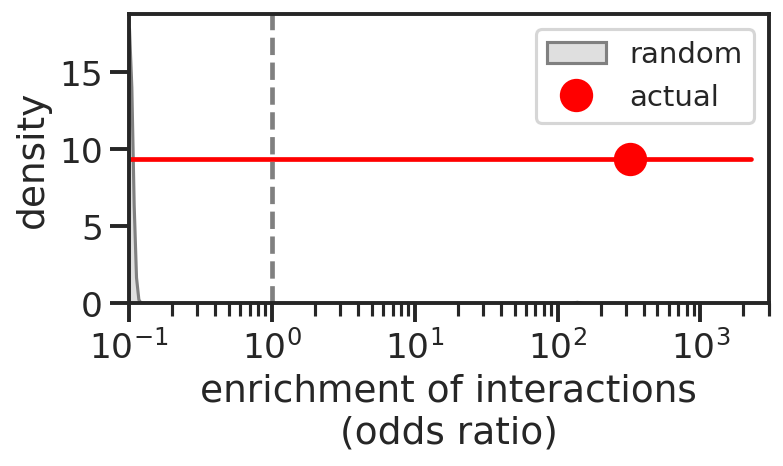

In [8]:
plt.figure(figsize=(5.5, 2.5))
sns.kdeplot(e[e['type'] != 'original']['odds-ratio'] + 0.1,
            bw_adjust=0.4,
            log_scale=True,
            color='grey', label='random',
            fill=True)
plt.plot(e[e['type'] == 'original']['odds-ratio'].values,
         plt.gca().get_ylim()[1] / 2,
         'ro', markersize=15,
         label='actual')
plt.plot([e[e['type'] == 'original']['low'].values[0] + 0.1,
          e[e['type'] == 'original']['high'].values[0]],
         [plt.gca().get_ylim()[1] / 2] * 2,
         'r-')
plt.axvline(1,
            color='grey', ls='dashed')
plt.ylabel('density')
plt.xlabel('enrichment of interactions\n(odds ratio)')
plt.legend(facecolor='w', fontsize=14)

plt.xlim(0.1, 3000)

plt.savefig('epistasis_extra_1.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('epistasis_extra_1.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);

In [9]:
mutated = get_rbd_mutated('../out/time-filtered-lineages/')

In [10]:
df = []
for name, idir in zip([1_000, 10_000,
                       100_000, 1_000_000],
                      ['../out/subsets-notime/'] * 4):
    df.append(read_mi(f'{idir}{name}/mi_annotated.tsv.gz', name, date=False))
df = pd.concat(df)

1000 [60.34431138         nan         nan]
10000 [155.46031746   0.         947.96129032]
100000 [ 302.49382716    0.         2100.51428571]
1000000 [ 302.49382716    0.         2100.51428571]


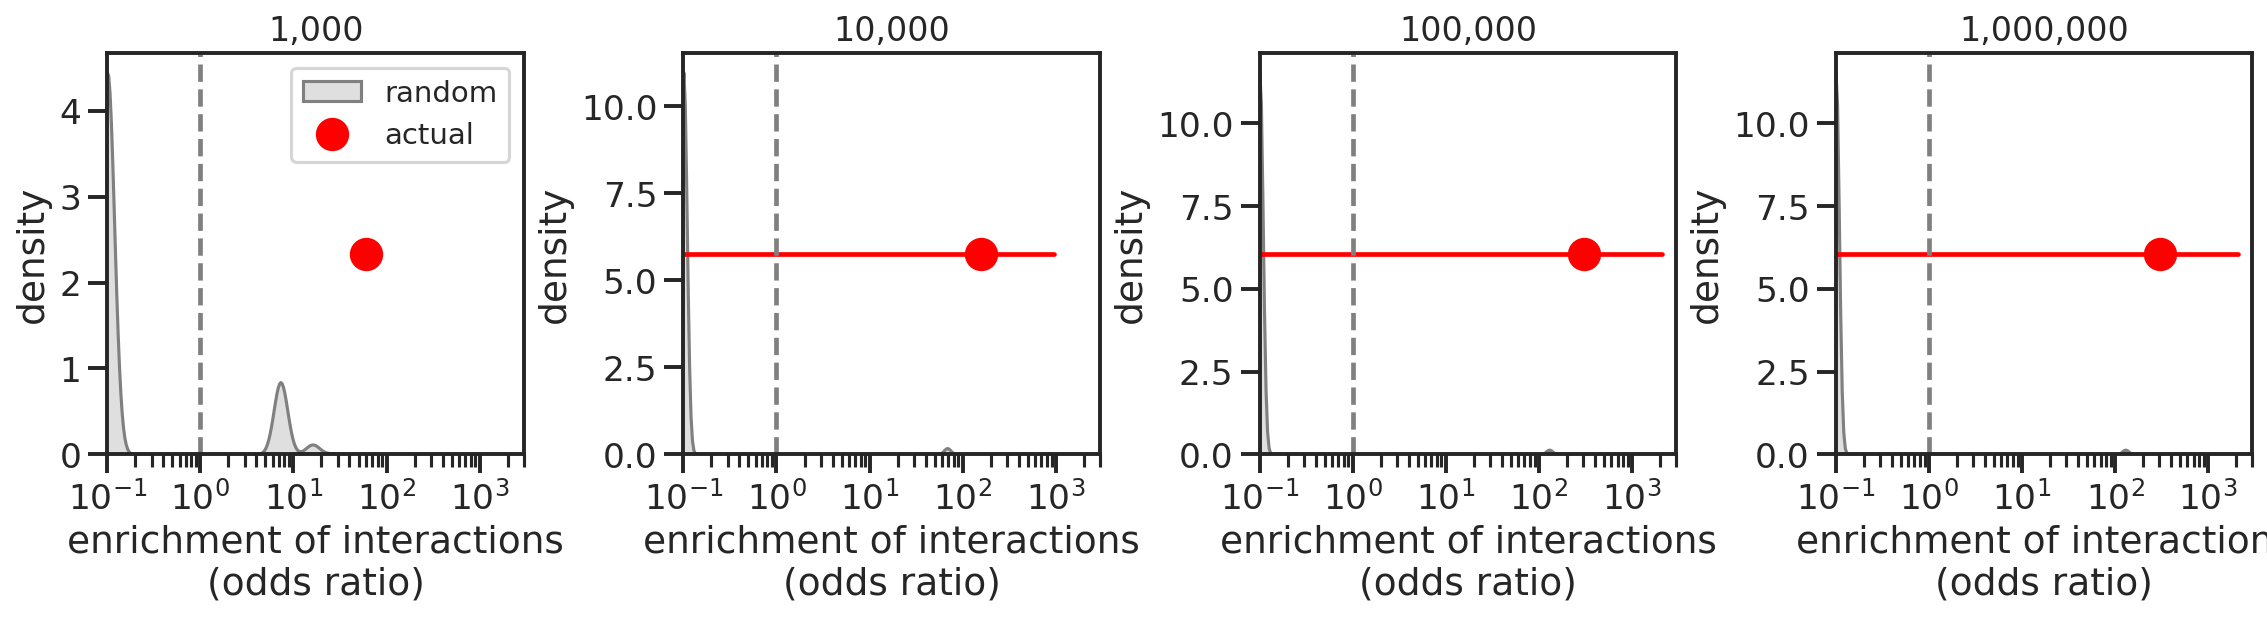

In [11]:
fig, axes = plt.subplots(1, 4,
                         figsize=(15, 4),
                         constrained_layout=True)

for ax, subset in zip(axes.flatten(),
                      [1_000,
                       10_000,
                       100_000,
                       1_000_000]):
    s = df[df['name'] == subset]
    
    o = enrichment(s, mutated)
    print(subset,
          o[o['type'] == 'original'][
          ['odds-ratio', 'low', 'high']].values[0])

    sns.kdeplot(o[o['type'] != 'original']['odds-ratio'] + 0.1,
                bw_adjust=0.4,
                log_scale=True,
                color='grey', label='random',
                fill=True,
                ax=ax)
    ax.plot(o[o['type'] == 'original']['odds-ratio'].values,
            ax.get_ylim()[1] / 2,
            'ro', markersize=15,
            label='actual')
    ax.plot([o[o['type'] == 'original']['low'].values[0] + 0.1,
             o[o['type'] == 'original']['high'].values[0]],
            [ax.get_ylim()[1] / 2] * 2,
            'r-')
    ax.axvline(1,
               color='grey', ls='dashed')
    ax.set_ylabel('density')
    ax.set_xlabel('enrichment of interactions\n(odds ratio)')
    if subset == 1_000:
        ax.legend(facecolor='w', fontsize=14)
    
    ax.set_xlim(0.1, 3000)

    ax.set_title(f'{subset:,}',
                 fontsize=16)

plt.savefig('epistasis_extra_2.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('epistasis_extra_2.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);

In [12]:
df = []
d_mutated = {}
all_mutated = set()
for name in sorted(os.listdir('../out/time-filtered-subsets/')):
    try:
        a = read_mi(f'../out/time-filtered-subsets/{name}/mi_annotated.tsv.gz',
                     name,
                     date=True)
        a = a[(a['gene_source'] == 'S') &
              (a['gene_target'] == 'S') &
              (a['feature_codon_source'] >= 319) &
              (a['feature_codon_source'] <= 540) &
              (a['feature_codon_target'] >= 319) &
              (a['feature_codon_target'] <= 540)]
        a['pair'] = ['%d-%d' % tuple(sorted([x, y]))
                     for x, y in a[['feature_codon_source',
                                    'feature_codon_target']].values]
        df.append(a)
        mutated = get_rbd_mutated('../out/time-filtered-lineages/',
                                  names=[name,])
        d_mutated[name] = mutated.union(all_mutated)
        all_mutated = mutated.union(all_mutated)
    except FileNotFoundError:
        pass
df = pd.concat(df)

In [13]:
s = df[(~df['name'].isin(['2020-02',
                          # '2020-03'
                         ])) &
       (df['gene_source'] == 'S') &
       (df['gene_target'] == 'S') &
       (df['pair'].isin(EPI_PAIRS))].copy()

s = s.pivot_table(index='pair',
                  columns='name',
                  values='outlier',
                  aggfunc='max').reindex(columns=sorted(df[~df['name'].isin(['2020-02',
                                                                            # '2020-03'
                                                                           ])]['name'].unique()))

s = s.reindex(EPI_PAIRS_SORTED)

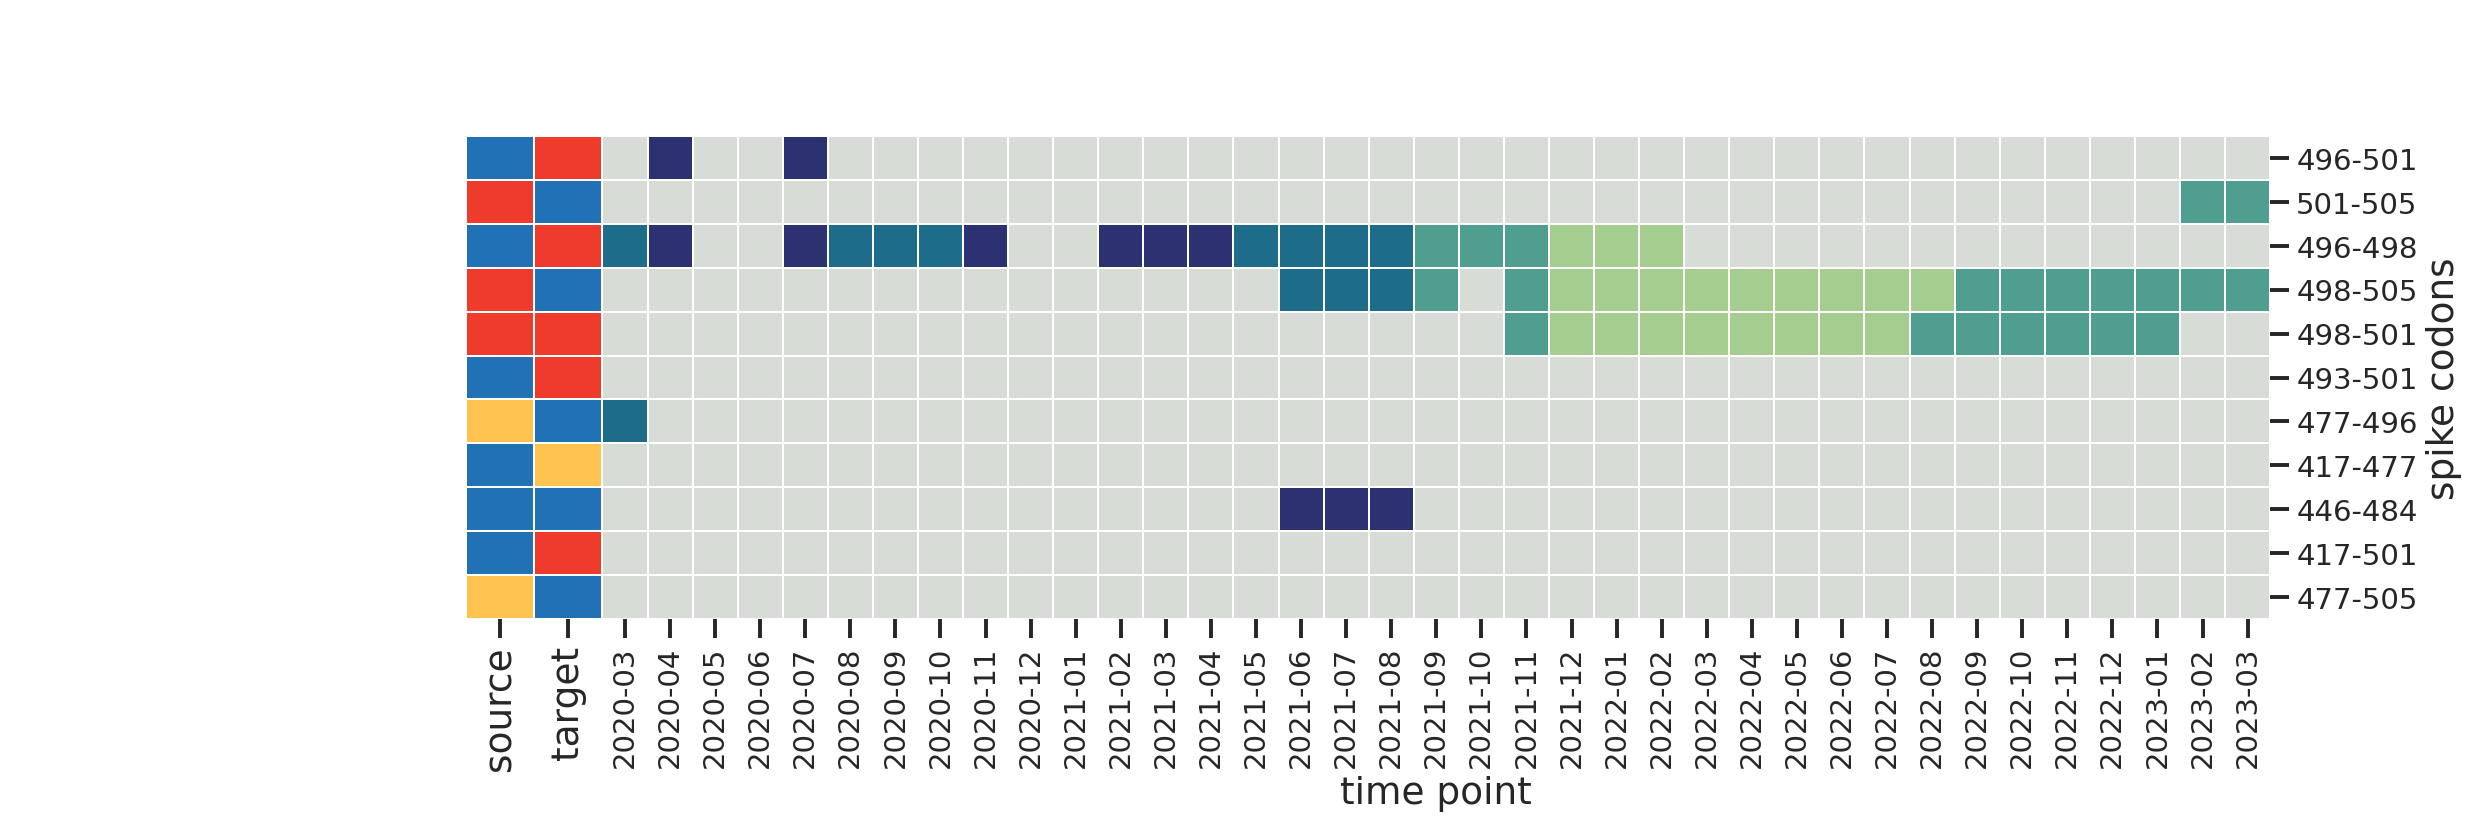

In [14]:
cmap = plt.get_cmap('crest_r').copy()
cmap.set_bad('xkcd:light grey')

colors1 = []
colors2 = []
for pair in s.index:
    x, y = pair.split('-')
    x = int(x)
    y = int(y)
    if x in AFFINITY:
        colors1.append('#ef3b2cff')
    elif x in ESCAPE:
        colors1.append('#2171b5ff')
    elif x in MOI:
        colors1.append('#fec44fff')
    else:
        colors1.append('xkcd:grey')

    if y in AFFINITY:
        colors2.append('#ef3b2cff')
    elif y in ESCAPE:
        colors2.append('#2171b5ff')
    elif y in MOI:
        colors2.append('#fec44fff')
    else:
        colors2.append('xkcd:grey')

cm = sns.clustermap(s, cmap=cmap,
                    row_cluster=False, col_cluster=False,
                    row_colors=pd.DataFrame([[a, b] for a, b in zip(colors1, colors2)],
                                            columns=['source', 'target'],
                                            index=s.index),
                    linewidths=0.005,
                    cbar_pos=None,
                    figsize=(17, 6),
                    vmin=1, vmax=4)

cm.ax_heatmap.set_xlabel('time point')
cm.ax_heatmap.set_ylabel('spike codons')

cm.ax_heatmap.set_xticks([x + 0.5 for x in range(s.shape[1])],
                         s.columns,
                         fontsize=14)
cm.ax_heatmap.set_yticks([x + 0.5 for x in range(s.shape[0])],
                         s.index,
                         fontsize=14)

cm.ax_row_colors.set_xticks([0.5, 1.5],
                            ['source', 'target'],
                            fontsize=18)

plt.savefig('epistasis_extra_3.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('epistasis_extra_3.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);

In [15]:
res = []
for name in sorted(df['name'].unique()):
    year = int(name.split('-')[0])
    month = int(name.split('-')[1])
    
    s = df[df['name'] == name]

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        o = enrichment(s, d_mutated[name])
    
    print(name)

    res.append(['actual', year, month, name,
                o[o['type'] == 'original']['odds-ratio'].values[0],
                o[o['type'] == 'original']['low'].values[0],
                o[o['type'] == 'original']['high'].values[0]])

    for odds_ratio in o[o['type'] == 'random']['odds-ratio'].values:
        res.append(['random', year, month, name, odds_ratio + 0.1, np.nan, np.nan])

r = pd.DataFrame(res,
                 columns=['set',
                          'year', 'month',
                          'name', 'odds-ratio',
                          'low', 'high'])
# r.groupby(['name', 'year', 'month', 'set']).mean().to_csv('enrichment_time.tsv',
#                                                           sep='\t')

2020-03
2020-04
2020-05
2020-06
2020-07
2020-08
2020-09
2020-10
2020-11
2020-12
2021-01
2021-02
2021-03
2021-04
2021-05
2021-06
2021-07
2021-08
2021-09
2021-10
2021-11
2021-12
2022-01
2022-02
2022-03
2022-04
2022-05
2022-06
2022-07
2022-08
2022-09
2022-10
2022-11
2022-12
2023-01
2023-02
2023-03


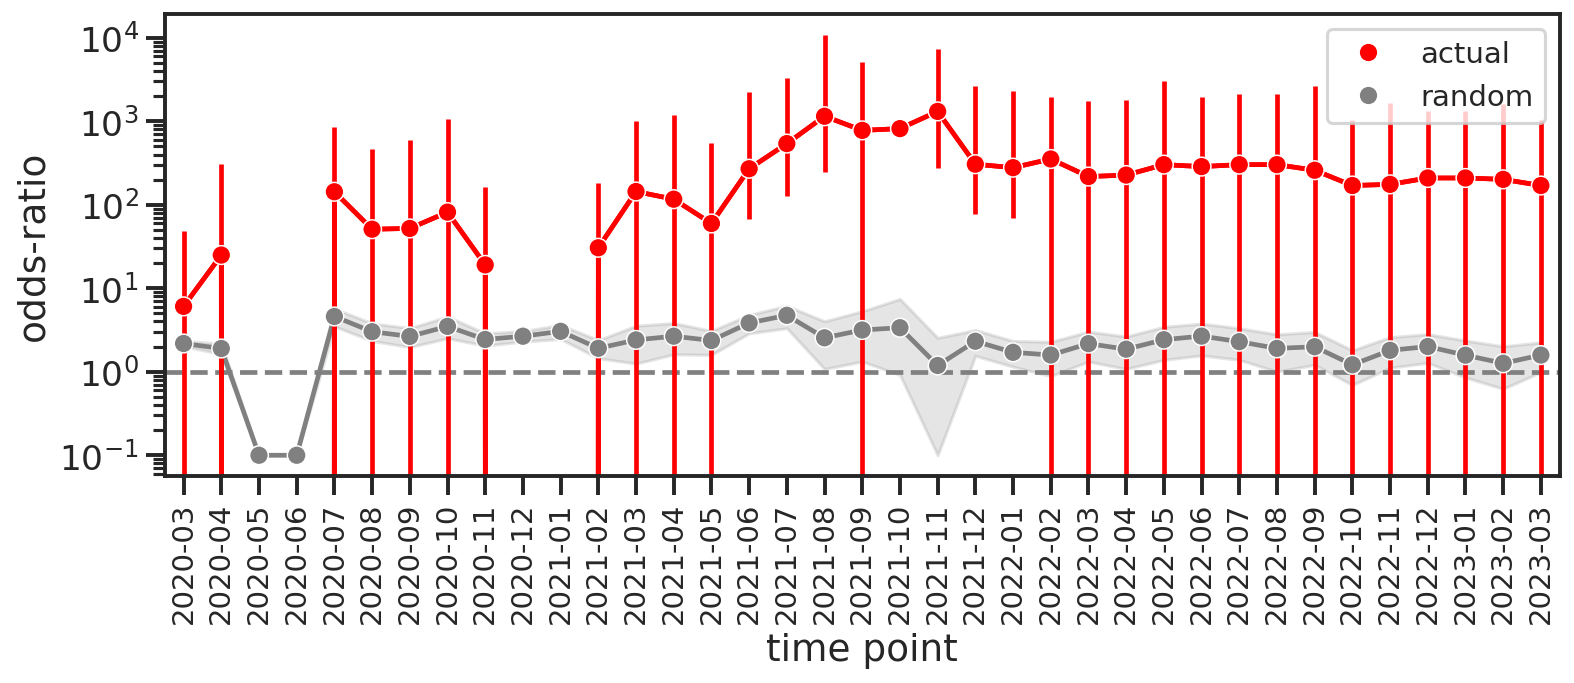

In [16]:
fig, ax = plt.subplots(figsize=(12, 4))

sns.lineplot(data=r,
             x='name',
             y='odds-ratio',
             hue='set',
             errorbar='ci',
             ax=ax,
             legend=False,
             palette=['r', 'grey'])
plt.errorbar(range(r['name'].unique().shape[0]),
             r[r['set'] == 'actual']['odds-ratio'],
             yerr=abs(r[r['set'] == 'actual'][['low', 'high']].T.values -
                      r[r['set'] == 'actual']['odds-ratio'].values),
             color='r')
sns.scatterplot(data=r.groupby(['name', 'set'])[['odds-ratio']].mean().reset_index(),
                x='name',
                y='odds-ratio',
                hue='set',
                ax=ax,
                palette=['r', 'grey'],
                zorder=10)

plt.axhline(1,
            color='grey', ls='dashed', zorder=-1)

plt.legend(facecolor='w', fontsize=14)

plt.xticks(rotation=90,
           fontsize=14)
plt.xlabel('time point')

plt.xlim(-0.5, r['name'].unique().shape[0] - 0.5)

# plt.ylim(0.0006, 15000)

plt.yscale('log')

plt.savefig('epistasis_extra_4.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('epistasis_extra_4.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);

In [17]:
df = []
d_mutated = {}
all_mutated = set()
for name in sorted(os.listdir('../out/time-filtered-subsets/')):
    try:
        a = read_mi(f'../out/time-filtered-subsets/{name}/mi_annotated_prefilter.tsv.gz',
                     name,
                     date=True)
        a = a[(a['gene_source'] == 'S') &
              (a['gene_target'] == 'S') &
              (a['feature_codon_source'] >= 319) &
              (a['feature_codon_source'] <= 540) &
              (a['feature_codon_target'] >= 319) &
              (a['feature_codon_target'] <= 540)]
        a['pair'] = ['%d-%d' % tuple(sorted([x, y]))
                     for x, y in a[['feature_codon_source',
                                    'feature_codon_target']].values]
        df.append(a)
        mutated = get_rbd_mutated('../out/time-filtered-lineages/',
                                  names=[name,])
        d_mutated[name] = mutated.union(all_mutated)
        all_mutated = mutated.union(all_mutated)
    except FileNotFoundError:
        pass
df = pd.concat(df)

/home/marco/workspace/2022_sarscov2_epistasis/notebooks/utils.py:46: DtypeWarning: Columns (6,10) have mixed types. Specify dtype option on import or set low_memory=False.
  a = pd.read_csv(fname, sep='\t')
/home/marco/workspace/2022_sarscov2_epistasis/notebooks/utils.py:46: DtypeWarning: Columns (6,10) have mixed types. Specify dtype option on import or set low_memory=False.
  a = pd.read_csv(fname, sep='\t')
/home/marco/workspace/2022_sarscov2_epistasis/notebooks/utils.py:46: DtypeWarning: Columns (6,10) have mixed types. Specify dtype option on import or set low_memory=False.
  a = pd.read_csv(fname, sep='\t')
/home/marco/workspace/2022_sarscov2_epistasis/notebooks/utils.py:46: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  a = pd.read_csv(fname, sep='\t')


In [18]:
s = df[(~df['name'].isin(['2020-02',
                          # '2020-03'
                         ])) &
       (df['gene_source'] == 'S') &
       (df['gene_target'] == 'S') &
       (df['pair'].isin(EPI_PAIRS))].copy()

s = s.pivot_table(index='pair',
                  columns='name',
                  values='outlier',
                  aggfunc='max').reindex(columns=sorted(df[~df['name'].isin(['2020-02',
                                                                            # '2020-03'
                                                                           ])]['name'].unique()))

s = s.reindex(EPI_PAIRS_SORTED)

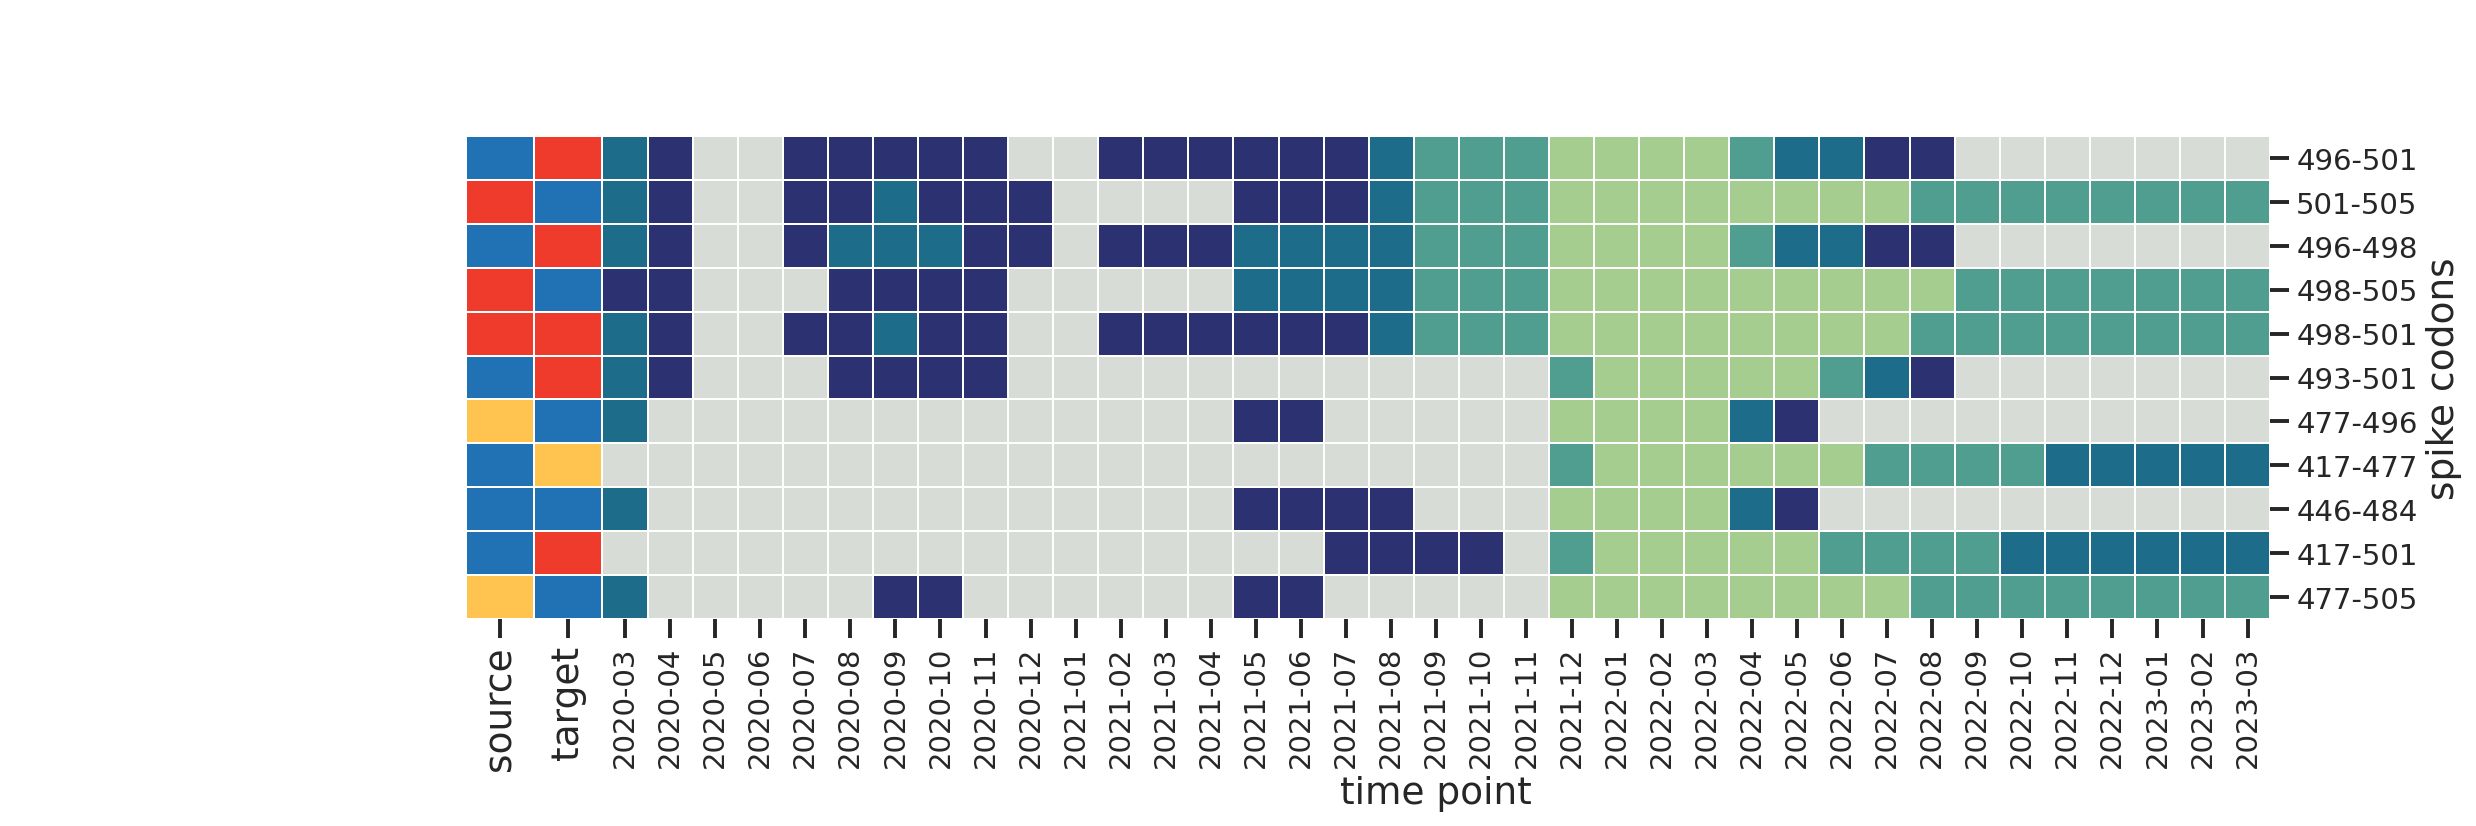

In [19]:
cmap = plt.get_cmap('crest_r').copy()
cmap.set_bad('xkcd:light grey')

colors1 = []
colors2 = []
for pair in s.index:
    x, y = pair.split('-')
    x = int(x)
    y = int(y)
    if x in AFFINITY:
        colors1.append('#ef3b2cff')
    elif x in ESCAPE:
        colors1.append('#2171b5ff')
    elif x in MOI:
        colors1.append('#fec44fff')
    else:
        colors1.append('xkcd:grey')

    if y in AFFINITY:
        colors2.append('#ef3b2cff')
    elif y in ESCAPE:
        colors2.append('#2171b5ff')
    elif y in MOI:
        colors2.append('#fec44fff')
    else:
        colors2.append('xkcd:grey')

cm = sns.clustermap(s, cmap=cmap,
                    row_cluster=False, col_cluster=False,
                    row_colors=pd.DataFrame([[a, b] for a, b in zip(colors1, colors2)],
                                            columns=['source', 'target'],
                                            index=s.index),
                    linewidths=0.005,
                    cbar_pos=None,
                    figsize=(17, 6),
                    vmin=1, vmax=4)

cm.ax_heatmap.set_xlabel('time point')
cm.ax_heatmap.set_ylabel('spike codons')

cm.ax_heatmap.set_xticks([x + 0.5 for x in range(s.shape[1])],
                         s.columns,
                         fontsize=14)
cm.ax_heatmap.set_yticks([x + 0.5 for x in range(s.shape[0])],
                         s.index,
                         fontsize=14)

cm.ax_row_colors.set_xticks([0.5, 1.5],
                            ['source', 'target'],
                            fontsize=18)

plt.savefig('epistasis_extra_5.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('epistasis_extra_5.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);

In [20]:
df = []
d_mutated = {}
all_mutated = set()
for name in sorted(os.listdir('../out/time-filtered-subsets/')):
    try:
        a = read_mi(f'../out/spikes/{name}/plmc.tsv.gz',
                     name,
                     date=True)
        a = a[(a['gene_source'] == 'S') &
              (a['gene_target'] == 'S') &
              (a['feature_codon_source'] >= 319) &
              (a['feature_codon_source'] <= 540) &
              (a['feature_codon_target'] >= 319) &
              (a['feature_codon_target'] <= 540)]
        a['pair'] = ['%d-%d' % tuple(sorted([x, y]))
                     for x, y in a[['feature_codon_source',
                                    'feature_codon_target']].values]
        df.append(a)
        mutated = get_rbd_mutated('../out/time-filtered-lineages/',
                                  names=[name,])
        d_mutated[name] = mutated.union(all_mutated)
        all_mutated = mutated.union(all_mutated)
    except FileNotFoundError:
        pass
df = pd.concat(df)

In [21]:
s = df[(~df['name'].isin(['2020-02',
                          # '2020-03'
                         ])) &
       (df['gene_source'] == 'S') &
       (df['gene_target'] == 'S') &
       (df['pair'].isin(EPI_PAIRS))].copy()

s = s.pivot_table(index='pair',
                  columns='name',
                  values='outlier',
                  aggfunc='max').reindex(columns=sorted(df[~df['name'].isin(['2020-02',
                                                                            # '2020-03'
                                                                           ])]['name'].unique()))

s = s.reindex(EPI_PAIRS_SORTED).T.reindex(sorted(os.listdir('../out/time-filtered-subsets/'))).T

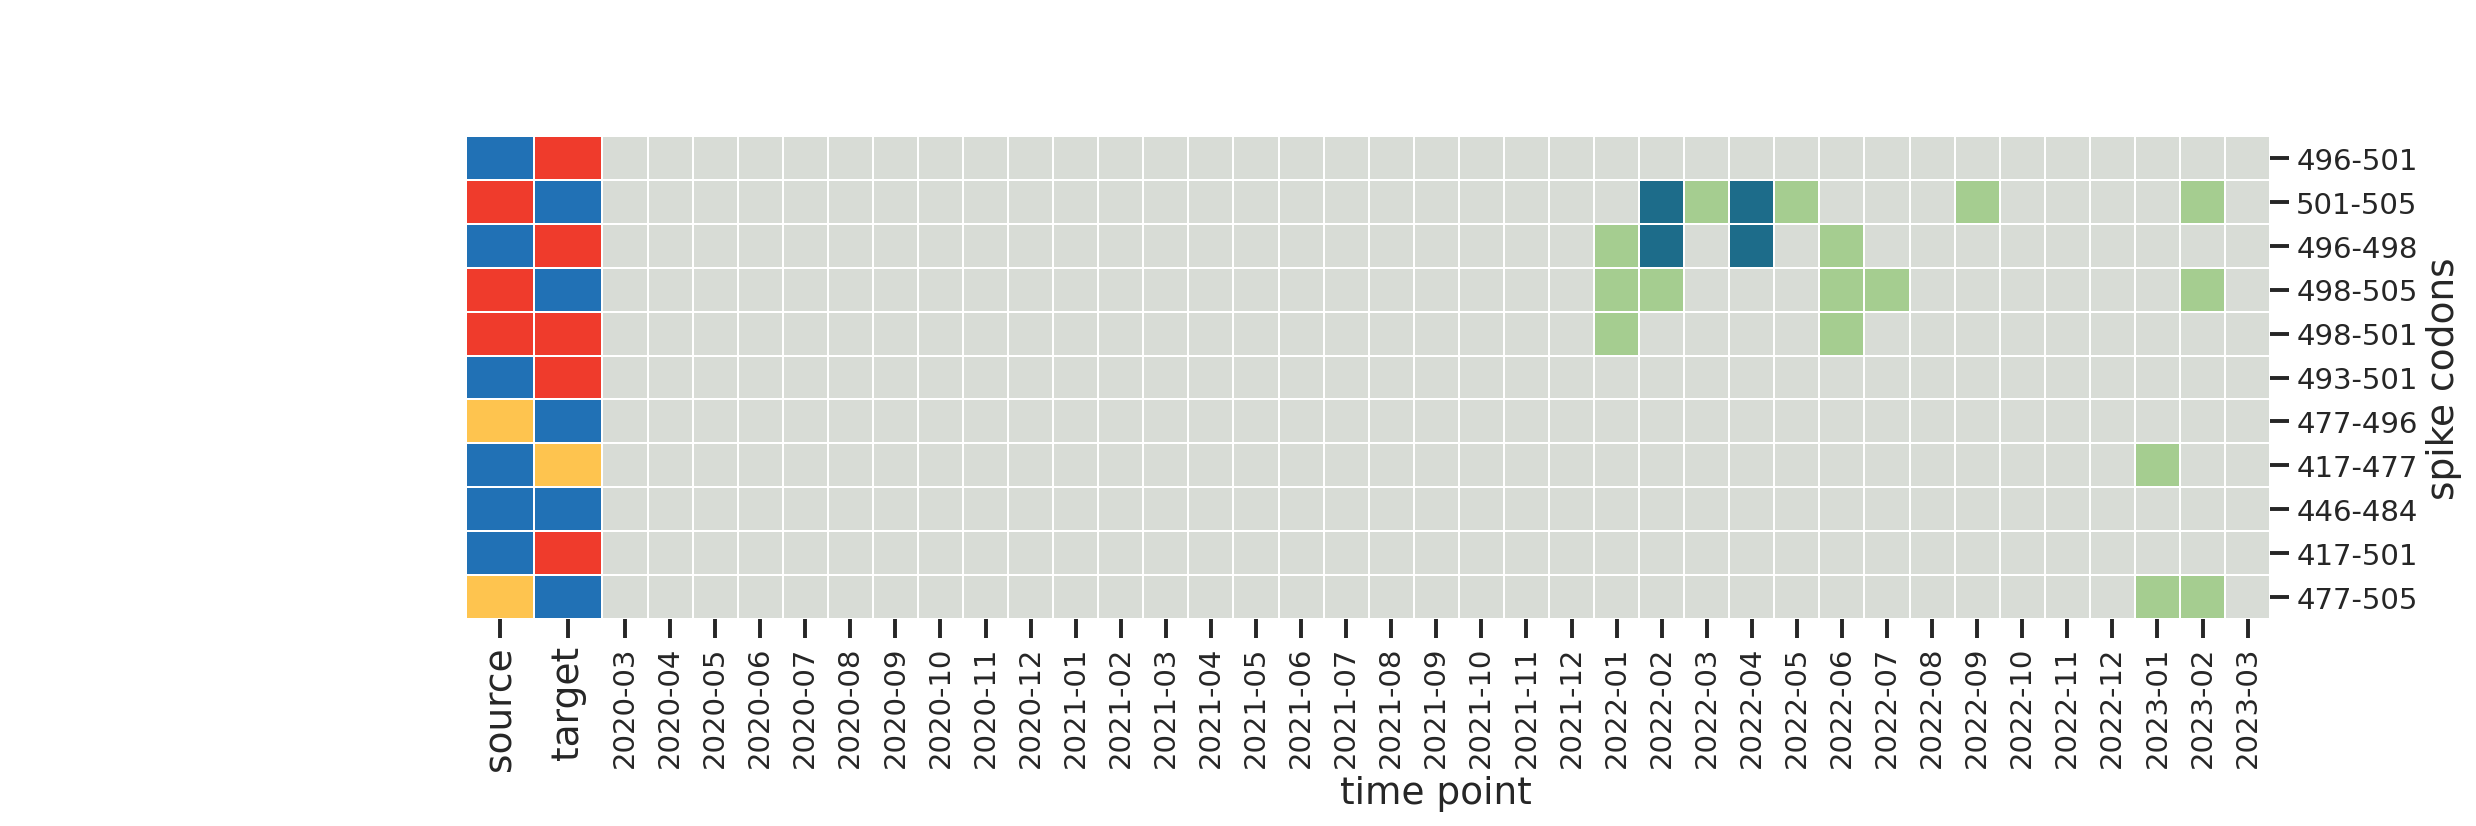

In [22]:
cmap = plt.get_cmap('crest_r').copy()
cmap.set_bad('xkcd:light grey')

colors1 = []
colors2 = []
for pair in s.index:
    x, y = pair.split('-')
    x = int(x)
    y = int(y)
    if x in AFFINITY:
        colors1.append('#ef3b2cff')
    elif x in ESCAPE:
        colors1.append('#2171b5ff')
    elif x in MOI:
        colors1.append('#fec44fff')
    else:
        colors1.append('xkcd:grey')

    if y in AFFINITY:
        colors2.append('#ef3b2cff')
    elif y in ESCAPE:
        colors2.append('#2171b5ff')
    elif y in MOI:
        colors2.append('#fec44fff')
    else:
        colors2.append('xkcd:grey')

cm = sns.clustermap(s, cmap=cmap,
                    row_cluster=False, col_cluster=False,
                    row_colors=pd.DataFrame([[a, b] for a, b in zip(colors1, colors2)],
                                            columns=['source', 'target'],
                                            index=s.index),
                    linewidths=0.005,
                    cbar_pos=None,
                    figsize=(17, 6),
                    vmin=1, vmax=4)

cm.ax_heatmap.set_xlabel('time point')
cm.ax_heatmap.set_ylabel('spike codons')

cm.ax_heatmap.set_xticks([x + 0.5 for x in range(s.shape[1])],
                         s.columns,
                         fontsize=14)
cm.ax_heatmap.set_yticks([x + 0.5 for x in range(s.shape[0])],
                         s.index,
                         fontsize=14)

cm.ax_row_colors.set_xticks([0.5, 1.5],
                            ['source', 'target'],
                            fontsize=18)

plt.savefig('epistasis_extra_6.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('epistasis_extra_6.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);

In [23]:
res = []
for name in sorted(os.listdir('../out/time-filtered-subsets/')):
    year = int(name.split('-')[0])
    month = int(name.split('-')[1])
    
    s = df[df['name'] == name]

    if s.shape[0] == 0:
        res.append(['actual', year, month, name,
                    np.nan, np.nan, np.nan])
        res.append(['random', year, month, name,
                    np.nan, np.nan, np.nan])
        continue

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        o = enrichment(s, d_mutated[name])
    
    print(name)

    res.append(['actual', year, month, name,
                o[o['type'] == 'original']['odds-ratio'].values[0],
                o[o['type'] == 'original']['low'].values[0],
                o[o['type'] == 'original']['high'].values[0]])

    for odds_ratio in o[o['type'] == 'random']['odds-ratio'].values:
        res.append(['random', year, month, name, odds_ratio + 0.1, np.nan, np.nan])

r = pd.DataFrame(res,
                 columns=['set',
                          'year', 'month',
                          'name', 'odds-ratio',
                          'low', 'high'])
# r.groupby(['name', 'year', 'month', 'set']).mean().to_csv('enrichment_time.tsv',
#                                                           sep='\t')

2021-09
2021-11
2021-12
2022-01
2022-02
2022-03
2022-04
2022-05
2022-06
2022-07
2022-08
2022-09
2022-10
2022-11
2022-12
2023-01
2023-02
2023-03


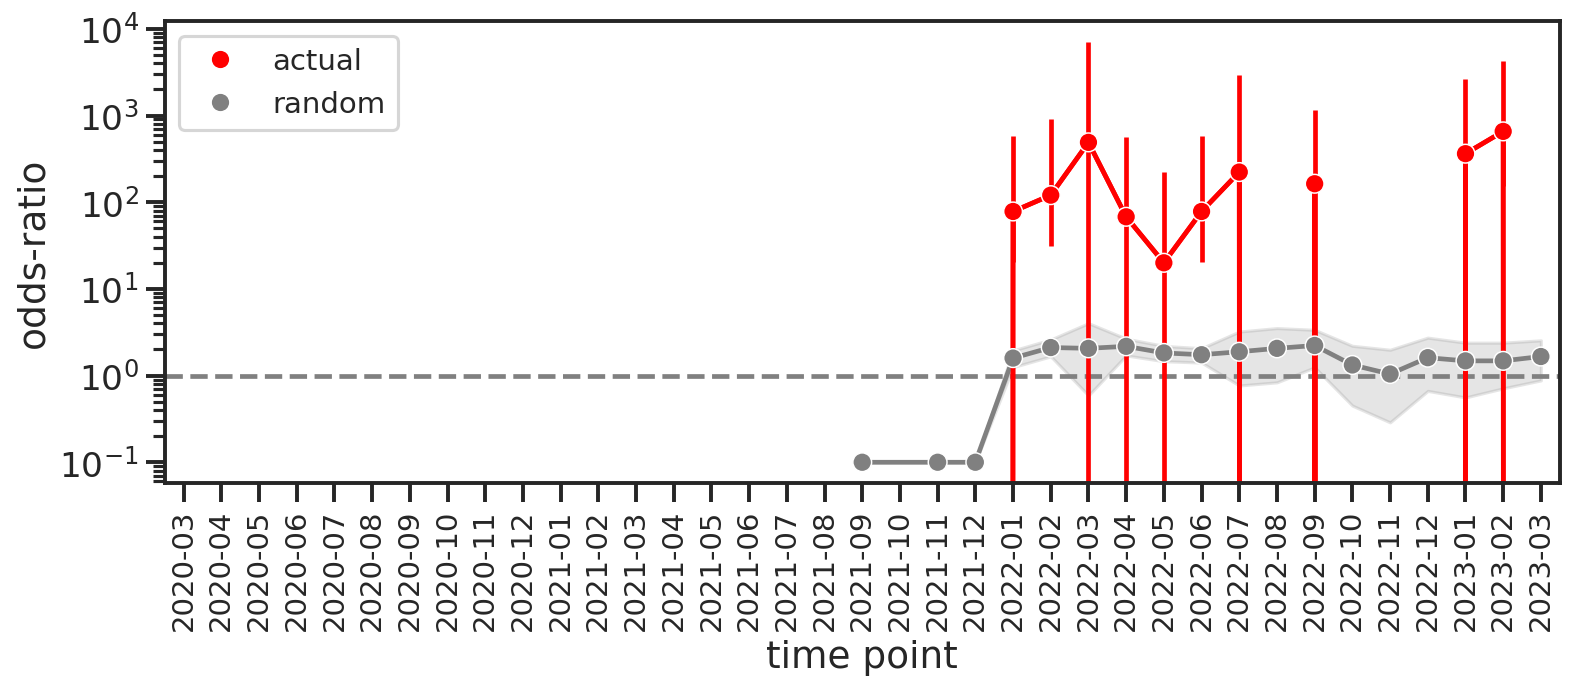

In [24]:
fig, ax = plt.subplots(figsize=(12, 4))

sns.lineplot(data=r,
             x='name',
             y='odds-ratio',
             hue='set',
             errorbar='ci',
             ax=ax,
             legend=False,
             palette=['r', 'grey'])
plt.errorbar(range(r['name'].unique().shape[0]),
             r[r['set'] == 'actual']['odds-ratio'],
             yerr=abs(r[r['set'] == 'actual'][['low', 'high']].T.values -
                      r[r['set'] == 'actual']['odds-ratio'].values),
             color='r')
sns.scatterplot(data=r.groupby(['name', 'set'])[['odds-ratio']].mean().reset_index(),
                x='name',
                y='odds-ratio',
                hue='set',
                ax=ax,
                palette=['r', 'grey'],
                zorder=10)

plt.axhline(1,
            color='grey', ls='dashed', zorder=-1)

plt.legend(facecolor='w', fontsize=14,
           loc='upper left')

plt.xticks(rotation=90,
           fontsize=14)
plt.xlabel('time point')

plt.xlim(-0.5, r['name'].unique().shape[0] - 0.5)

# plt.ylim(0.0006, 15000)

plt.yscale('log')

plt.savefig('epistasis_extra_7.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('epistasis_extra_7.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);